# Libraries

In [1]:
# General data manipulation
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import sys
import time
from PIL import Image # pip install pillow
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Deep learning setup (NN, CNN)
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, AveragePooling2D

In [3]:
# Model evaluation
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Read from .pkl

In [4]:
%%time
er_data = pd.read_pickle('er_data(1-6758).pkl')
nr_data = pd.read_pickle('nr_data(1-6646).pkl')

CPU times: user 1.81 s, sys: 6.06 s, total: 7.87 s
Wall time: 41.6 s


In [7]:
er_data.head(3)

,img_array,type_2_ER,energy
0,"[[104, 104, 101, 101, 101, 101, 97, 104, 96, 1...",1,10
1,"[[98, 97, 103, 104, 104, 98, 99, 102, 101, 97,...",1,3
2,"[[102, 97, 100, 96, 100, 97, 94, 110, 97, 100,...",1,10


In [7]:
nr_data.head(3)

,img_array,type_2_ER,energy
0,"[[96, 103, 98, 100, 100, 100, 108, 96, 99, 100...",0,20
1,"[[96, 104, 104, 98, 98, 100, 97, 103, 100, 100...",0,1
2,"[[101, 98, 106, 99, 99, 97, 97, 100, 102, 104,...",0,6


In [8]:
# full
input_df = er_data.append(nr_data)

In [5]:
# check ER
input_df = er_data.iloc[:,0:2000]

## Data Preprocessing
1. reshape for CNN input
2. Centralisation (image cropping)
3. Type conversion (float)
4. Noise reduction 

In [8]:
# Shuffle
er_data = er_data.sample(frac=1).reset_index(drop=True)
nr_data = nr_data.sample(frac=1).reset_index(drop=True)

In [9]:
# take 2000 each from er and nr
n = 2000
input_df = er_data.iloc[0:n,].append(nr_data.iloc[0:n,])

In [6]:
img_array = np.array(list(input_df.img_array))
img_array.shape

(6758, 576, 576)

In [7]:
# 1. reshape the matrix for CNN input
img_array = img_array.reshape(img_array.shape[0],576,576,1)
img_array.shape

(6758, 576, 576, 1)

In [8]:
# 2. centralisation (576-224-224 = 128)
c = 224
img_array = img_array[:,c:576-c,c:576-c,:]
img_array.shape

(6758, 128, 128, 1)

In [ ]:
# 3. type conversion
img_array = img_array.astype(float)

In [14]:
%%time
# 4. noise reduction
from scipy.ndimage import *
img_array = grey_closing(gaussian_gradient_magnitude(img_array,5), 9)

CPU times: user 1min 3s, sys: 1.66 s, total: 1min 4s
Wall time: 1min 4s


In [15]:
# %time
# # Normalization
# # img_array = img_array.astype('float')
# img_array /= 255

In [16]:
target_data = np.array(input_df.type_2_ER)
target_data = target_data.reshape(len(input_df),1)

In [17]:
# Convert 1-dimensional class arrays to 2-dimensional class matrices
# target_data = np.array(input_df.type_2_ER)
# target_data = np_utils.to_categorical(input_df.energy, 6)
# target_data = target_data.reshape(len(input_df),6)

-----------------------------------------------------------------------------

# Train and Test data split

In [18]:
print(img_array.shape)
print(target_data.shape)

(4000, 128, 128, 1)
(4000, 1)


In [19]:
# Train and Test data Split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    img_array, target_data, test_size=0.3)

# Model Run

## Part 1. Predicting type of graphs (ER/NR)

In [20]:
# CNN for graphic data
#create model
cnn_type = Sequential()
#add model layers
cnn_type.add(Conv2D(16, kernel_size=9, activation='relu', input_shape=(128,128,1)))
cnn_type.add(MaxPooling2D(pool_size=(2, 2)))
cnn_type.add(Conv2D(32, kernel_size=5, activation='relu'))
# cnn_type.add(Dropout(0.5))
cnn_type.add(MaxPooling2D(pool_size=(2, 2)))
cnn_type.add(Conv2D(64, kernel_size=3, activation='relu'))
cnn_type.add(MaxPooling2D(pool_size=(2, 2)))
# cnn_type.add(Conv2D(128, kernel_size=3, activation='relu'))
cnn_type.add(Flatten())
cnn_type.add(Dense(128, activation='relu'))
cnn_type.add(Dense(1, activation='sigmoid'))
# cnn_type.add(Dense(2, activation='softmax'))


cnn_type.compile(optimizer='adam',
#     loss='categorical_crossentropy',
    loss='binary_crossentropy',
    metrics=['accuracy'])

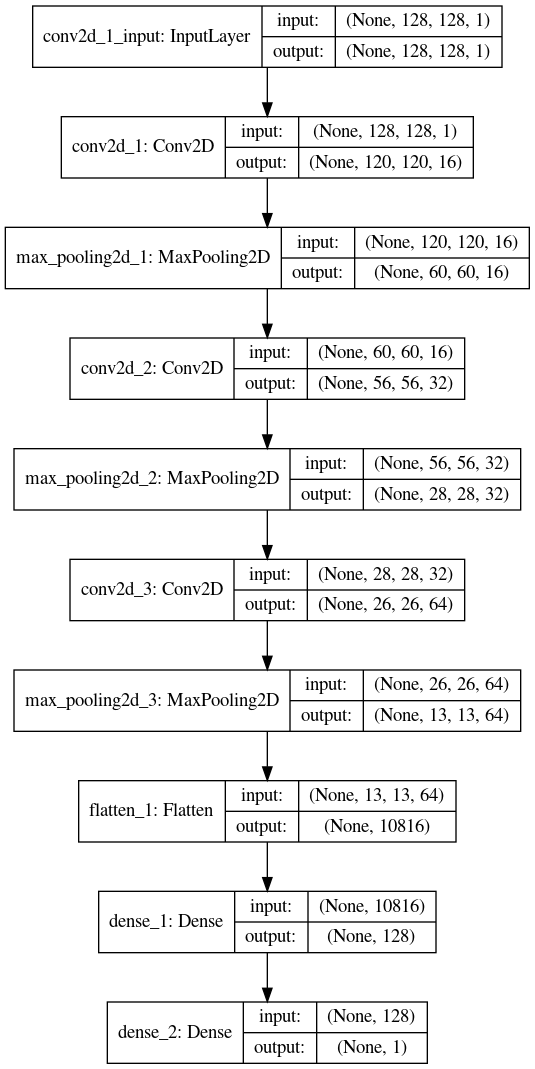

In [21]:
from keras.utils import plot_model
plot_model(cnn_type, show_shapes=True)

In [22]:
%%time 
cnn_type_model = cnn_type.fit(x_train, y_train, 
                              batch_size=64,
                              epochs=10,
                              # verbose=1,
                              validation_data=(x_test, y_test))

Train on 2800 samples, validate on 1200 samples
Epoch 1/10
2800/2800 [==============================] - 55s 20ms/step - loss: 0.1300 - accuracy: 0.9443 - val_loss: 0.0041 - val_accuracy: 0.9992
Epoch 2/10
2800/2800 [==============================] - 54s 19ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9992
Epoch 3/10
2800/2800 [==============================] - 80s 29ms/step - loss: 3.6538e-04 - accuracy: 1.0000 - val_loss: 9.0368e-04 - val_accuracy: 0.9992
Epoch 4/10
2800/2800 [==============================] - 87s 31ms/step - loss: 7.7757e-05 - accuracy: 1.0000 - val_loss: 6.7634e-04 - val_accuracy: 0.9992
Epoch 5/10
2800/2800 [==============================] - 87s 31ms/step - loss: 4.4777e-05 - accuracy: 1.0000 - val_loss: 3.1894e-04 - val_accuracy: 1.0000
Epoch 6/10
2800/2800 [==============================] - 88s 31ms/step - loss: 3.0790e-05 - accuracy: 1.0000 - val_loss: 4.2968e-04 - val_accuracy: 1.0000
Epoch 7/10
2800/2800 [======================

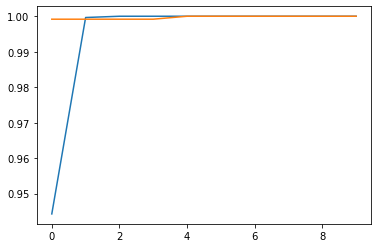

In [23]:
plt.plot(cnn_type_model.history['accuracy'])
plt.plot(cnn_type_model.history['val_accuracy'])

In [24]:
score, acc = cnn_type.evaluate(x_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

1200/1200 [==============================] - 10s 8ms/step
Test score: 0.00027453344430568906
Test accuracy: 1.0


In [26]:
cnn_type.save('CNN_1(Tommy)-final.h5')

# Test data

In [27]:
# Prediction on testing data
y_pred = np.round(cnn_type.predict(x_test))

In [28]:
# Generate the classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       583
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



### Confusion Matrix

In [29]:
cm = confusion_matrix(y_test,y_pred) # create a confusion matrix

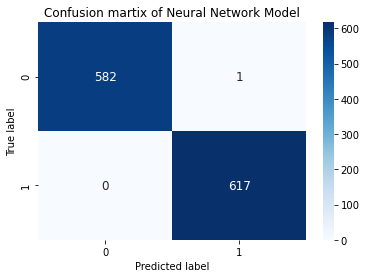

In [30]:
# Plot the confusion matrix
import seaborn as sns
sns.heatmap(cm,
            cmap=plt.cm.Blues,
            annot=True, 
            annot_kws={"size": 12}, 
            fmt="d") # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion martix of Neural Network Model')
plt.show()

# Part 2: Predicting Energy level based on type of graphs

## 1. ER

### Data import

In [5]:
# full
input_df = er_data.append(nr_data)

In [10]:
input_df_er = input_df[input_df.type_2_ER == 1]
input_df_er.head()

,img_array,type_2_ER,energy
0,"[[104, 104, 101, 101, 101, 101, 97, 104, 96, 1...",1,10
1,"[[98, 97, 103, 104, 104, 98, 99, 102, 101, 97,...",1,3
2,"[[102, 97, 100, 96, 100, 97, 94, 110, 97, 100,...",1,10
3,"[[101, 96, 100, 99, 96, 108, 104, 102, 101, 99...",1,30
4,"[[97, 98, 100, 101, 98, 100, 102, 100, 99, 99,...",1,10


In [6]:
# Shuffle
input_df_er = input_df_er.sample(frac=1).reset_index(drop=True)

NameError: name 'input_df_er' is not defined

In [12]:
no_of_energy_er = len(set(input_df_er.energy))

In [13]:
set(input_df_er.energy)

{'1', '10', '20', '3', '30', '6'}

### Data Preprocessing

In [7]:
img_array = np.array(list(input_df_er.img_array))
img_array.shape

NameError: name 'input_df_er' is not defined

In [15]:
# 1. reshape the matrix for CNN input
img_array = img_array.reshape(img_array.shape[0],576,576,1)
img_array.shape

(6758, 576, 576, 1)

In [16]:
# 2. centralisation (576-224-224 = 128)
c = 224
img_array = img_array[:,c:576-c,c:576-c,:]
img_array.shape

(6758, 128, 128, 1)

In [17]:
# select 4000 data
img_array = img_array[0:4000]

In [18]:
# 3. type conversion
img_array = img_array.astype(float)

In [19]:
%%time
# 4. noise reduction
from scipy.ndimage import *
img_array = grey_closing(gaussian_gradient_magnitude(img_array,5), 9)

CPU times: user 1min 31s, sys: 1.98 s, total: 1min 33s
Wall time: 1min 34s


In [21]:
target_data = np.array(input_df_er[0:4000].energy)
target_data = target_data.reshape(len(input_df_er[0:4000]),1)

In [22]:
target_data = target_data.astype(int)

In [63]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
from keras.utils import np_utils # data preprocessing
target_data = np.array(input_df_er[0:4000].energy)
target_data = target_data.reshape(len(input_df_er[0:4000]),1)
target_data = np_utils.to_categorical(target_data, 31)
target_data.shape

(4000, 31)

### Train Test data split

In [23]:
print(img_array.shape)
print(target_data.shape)

(4000, 128, 128, 1)
(4000, 1)


In [67]:
# Train and Test data Split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    img_array, target_data, test_size=0.3)

### Model Run

In [25]:
import tensorflow as tf
mae = tf.keras.losses.MeanAbsoluteError()

In [64]:
# CNN for graphic data
#create model
cnn_energy_er = Sequential()
#add model layers
cnn_energy_er.add(Conv2D(16, kernel_size=9, activation='relu', input_shape=(128,128,1)))
cnn_energy_er.add(MaxPooling2D(pool_size=(2, 2)))
cnn_energy_er.add(Conv2D(32, kernel_size=5, activation='relu'))
# cnn_energy_er.add(Dropout(0.5))
cnn_energy_er.add(MaxPooling2D(pool_size=(2, 2)))
cnn_energy_er.add(Conv2D(64, kernel_size=3, activation='relu'))
cnn_energy_er.add(MaxPooling2D(pool_size=(2, 2)))
# cnn_energy_er.add(Conv2D(128, kernel_size=3, activation='relu'))
cnn_energy_er.add(Flatten())
cnn_energy_er.add(Dense(128, activation='relu'))
# cnn_energy_er.add(Dense(1, activation='sigmoid'))
cnn_energy_er.add(Dense(31))


cnn_energy_er.compile(optimizer='adam',
    loss='categorical_crossentropy',
#     loss=mae,
    metrics=['mean_absolute_error'])

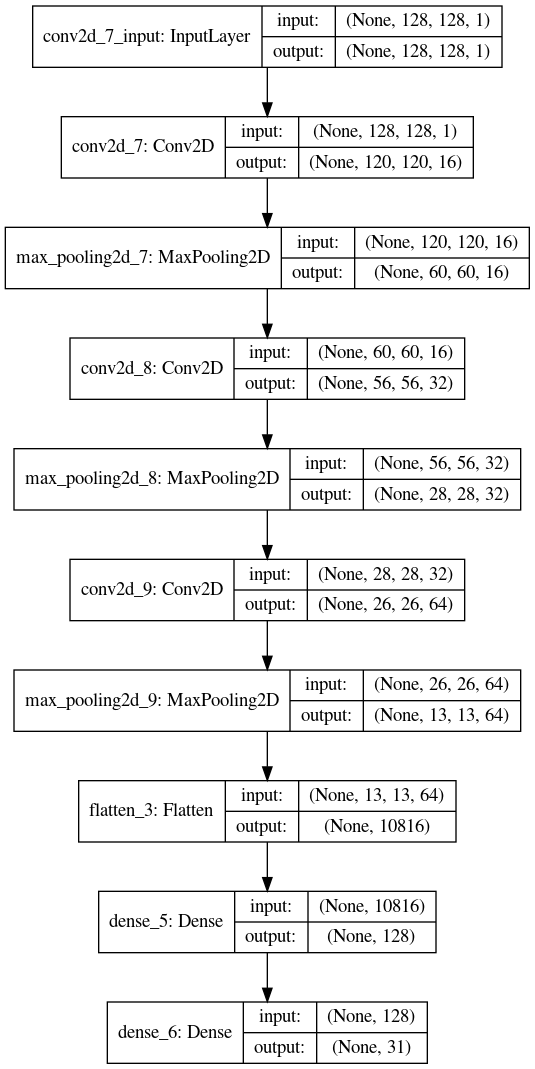

In [65]:
from keras.utils import plot_model
plot_model(cnn_energy_er, show_shapes=True)

In [68]:
%%time 
cnn_energy_er_model = cnn_energy_er.fit(x_train, y_train, 
                              batch_size=64,
                              epochs=10,
                              # verbose=1,
                              validation_data=(x_test, y_test))

Train on 2800 samples, validate on 1200 samples
Epoch 1/10
2800/2800 [==============================] - 68s 24ms/step - loss: 7.3419 - mean_absolute_error: 2.9569 - val_loss: 5.4812 - val_mean_absolute_error: 5.1398
Epoch 2/10
2800/2800 [==============================] - 67s 24ms/step - loss: 5.4642 - mean_absolute_error: 5.3346 - val_loss: 5.4809 - val_mean_absolute_error: 5.4016
Epoch 3/10
2800/2800 [==============================] - 68s 24ms/step - loss: 5.4634 - mean_absolute_error: 5.4062 - val_loss: 5.4802 - val_mean_absolute_error: 5.4464
Epoch 4/10
2800/2800 [==============================] - 68s 24ms/step - loss: 9.1816 - mean_absolute_error: 5.5275 - val_loss: 10.6379 - val_mean_absolute_error: 5.5645
Epoch 5/10
2800/2800 [==============================] - 68s 24ms/step - loss: 10.6552 - mean_absolute_error: 5.5583 - val_loss: 10.6379 - val_mean_absolute_error: 5.5661
Epoch 6/10
2800/2800 [==============================] - 68s 24ms/step - loss: 10.6552 - mean_absolute_error: 

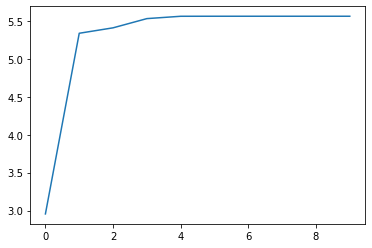

In [69]:
# plt.plot(cnn_energy_er_model.history['mean_squared_error'])
plt.plot(cnn_energy_er_model.history['mean_absolute_error'])

In [70]:
cnn_energy_er.save('CNN_energy_ER(Tommy).h5')

In [71]:
%time
# Prediction on testing data
y_pred = cnn_energy_er.predict(x_test)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs


In [75]:
y_test.shape

(1200, 31)

In [72]:
result = pd.DataFrame()

result['pred'] = y_pred.reshape(len(y_pred)).tolist()
result['test'] = y_test.reshape(len(y_test)).tolist()

ValueError: cannot reshape array of size 37200 into shape (1200,)

In [81]:
list(y_pred[1]).index(max(list(y_pred[1])))

3

In [79]:
y_test[1]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [84]:
def conv_to_number(x):
    return list(x).index(max(list(x)))

In [85]:
predict_list = []

In [86]:
for each in y_pred:
    predict_list.append(conv_to_number(each))

# Load model

In [11]:
from tensorflow import keras
model_cnn_1 = keras.models.load_model('CNN_1(Tommy)-final.h5')

In [ ]:
score, acc = cnn_type.evaluate(x_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)